# Playing around with signal classes

Here we are prototyping representing mixed complex valued signals. A signal is a complex valued function of time, of the form $s(t) = f(t)e^{i 2 \pi \nu t}$, where $f$ is the envelope function, and $\nu$ is the carrier frequency.

In [1]:
import sys
sys.path.insert(1, '../models/')

import numpy as np
from signals_new import Signal, Constant, ConstantSignal, PiecewiseConstant
from matplotlib import pyplot as plt

## 1. Signals specified as functions

The most general signal object is given by specification of the envelope as a python callable function, and a frequency.

In [2]:
test_sig = Signal(envelope=lambda t: t**2, 
                  carrier_freq=2.)

We can plot it (this gives the real and complex part).

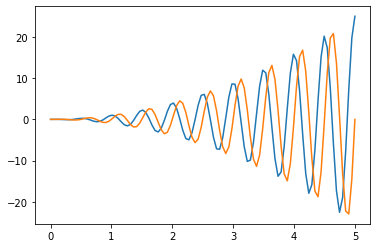

In [3]:
test_sig.plot(0, 5, 100)

We can also plot just the envelope.

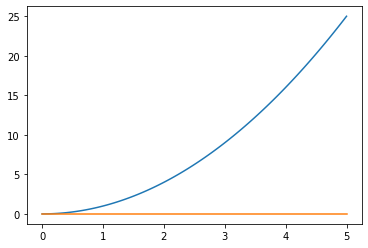

In [4]:
test_sig.plot_envelope(0, 5, 100)

# 2. Constants

Constants are implemented as a subclass of `Signal` with a constant value and `0` carrier frequency. This allows a parameter to be recognized as constant but still be worked with in the same way as a general mixed signal.

In [5]:
constant = Constant(2.)

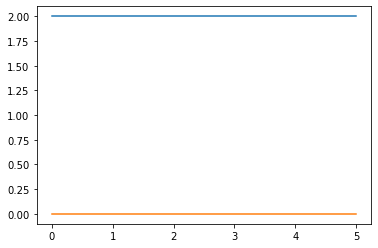

In [6]:
constant.plot(0, 5, 100)

# 3. ConstantSignal

A constant signal is a signal with constant envelope but with potentially non-zero carrier frequency. It is distinguished from `Constant` in that it is more of a convenience for specifying time-dependent signals. These should not be treated as `Constant` even if the carrier frequency is `0`.

In [7]:
constant_sig = ConstantSignal(value=2., carrier_freq=0.1)

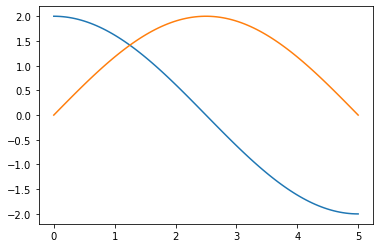

In [8]:
constant_sig.plot(0, 5, 100)

# 4. PiecewiseConstant

Signals with piecewise constant envelopes specified as a list of samples, along with a `dt` value specifying the length of each sample.

In [9]:
dt = 1.
samples = np.array([0.,0.,1.,2.,1.,0.,0.])
carrier_freq = 0.5

piecewise_const = PiecewiseConstant(dt=dt, samples=samples, carrier_freq=carrier_freq)

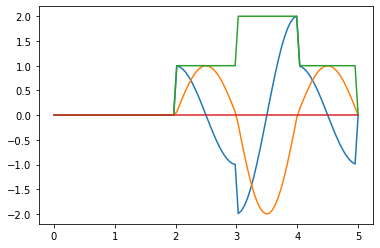

In [10]:
piecewise_const.plot(0, 5, 100)
piecewise_const.plot_envelope(0, 5, 100)

# 5. Adding and multiplying signals

Multiplying and adding signals produces a new signal. The most general version of this simply treats them as general signals. E.g. to multiply two general signals, a new envelope function is constructed from the old, and a new signal is instantiated with this envelope function with the carrier frequency given by the sum.

Addition is a bit less clean - when two signals are added it is checked if they have the same carrier frequency - if they do the envelope functinos are simply added together. If the carrier frequencies are different, the current behaviour is to create a new signal with $0$ carrier frequency and envelope function constructed from the full signals added together.

The addition/multiplication routines also attempt to preserve special types. E.g. if two Constants are added together the result is a new Constant. The current special rules are very simple, but regardless of type if a special rule doesn't exist we can always add/multiply them as general signals.

In [11]:
# adding constants together produces another constant
constant + constant

Constant(4.0)

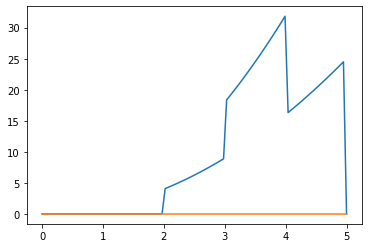

In [12]:
# multiply two signals and plot the resulting envelope
(test_sig*piecewise_const).plot_envelope(0, 5, 100)

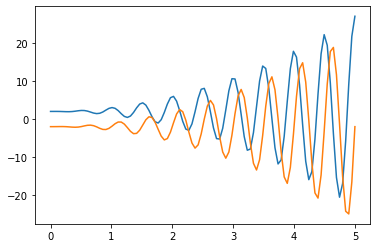

In [13]:
# add a constant to a signal
(2-2j + test_sig).plot(0, 5, 100)

In [14]:
#add two compatible piecewise constant signals (same start time, duration, dt)
type(piecewise_const + piecewise_const)

signals_new.PiecewiseConstant

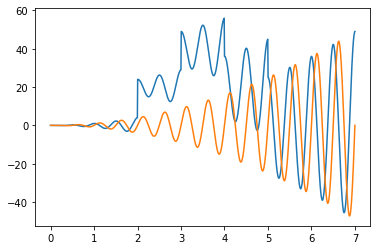

In [16]:
(test_sig + 20*piecewise_const).plot(0, 7, 1000)